In [21]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imageio
import torch
# k=['/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-A-B-2_203201.png',
# '/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-A-B-3_203201.png',
# '/ssd/hk/Syria_samples/samples_enhance_size6_AREA_v2/post/Aleppo_enhance-A-B-2_203201.pth',
# '/ssd/hk/Syria_samples/samples_enhance_size6_AREA_v2/post/Aleppo_enhance-A-B-3_203201.pth']
k=  ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Aleppo_enhance-B-C-1_030232.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-B-C-1_030232.png',
     '/ssd/hk/Syria_samples/samples_enhance_size6_AREA_v2/pre/Aleppo_enhance-B-C-1_030232.pth',
     '/ssd/hk/Syria_samples/samples_enhance_size6_AREA_v2/post/Aleppo_enhance-B-C-1_030232.pth',]

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def smooth(image, sigma = 1.4, length = 5):
    """ Smooth the image
    Compute a gaussian filter with sigma = sigma and kernal_length = length.
    Each element in the kernal can be computed as below:
        G[i, j] = (1/(2*pi*sigma**2))*exp(-((i-k-1)**2 + (j-k-1)**2)/2*sigma**2)
    Then, use the gaussian filter to smooth the input image.

    Args:
        image: array of grey image
        sigma: the sigma of gaussian filter, default to be 1.4
        length: the kernal length, default to be 5

    Returns:
        the smoothed image
    """
    # Compute gaussian filter
    k = length // 2
    gaussian = np.zeros([length, length])
    for i in range(length):
        for j in range(length):
            gaussian[i, j] = np.exp(-((i-k) ** 2 + (j-k) ** 2) / (2 * sigma ** 2))
    gaussian /= 2 * np.pi * sigma ** 2
    # Batch Normalization
    gaussian = gaussian / np.sum(gaussian)

    # Use Gaussian Filter
    W, H = image.shape
    new_image = np.zeros([W - k * 2, H - k * 2])

    for i in range(W - 2 * k):
        for j in range(H - 2 * k):
            # 卷积运算
            new_image[i, j] = np.sum(image[i:i+length, j:j+length] * gaussian)

    new_image = np.uint8(new_image)
    return new_image

def get_gradient_and_direction(image):
    """ Compute gradients and its direction
    Use Sobel filter to compute gradients and direction.
         -1 0 1        -1 -2 -1
    Gx = -2 0 2   Gy =  0  0  0
         -1 0 1         1  2  1

    Args:
        image: array of grey image

    Returns:
        gradients: the gradients of each pixel
        direction: the direction of the gradients of each pixel
    """
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    W, H = image.shape
    gradients = np.zeros([W - 2, H - 2])
    direction = np.zeros([W - 2, H - 2])

    for i in range(W - 2):
        for j in range(H - 2):
            dx = np.sum(image[i:i+3, j:j+3] * Gx)
            dy = np.sum(image[i:i+3, j:j+3] * Gy)
            gradients[i, j] = np.sqrt(dx ** 2 + dy ** 2)
            if dx == 0:
                direction[i, j] = np.pi / 2
            else:
                direction[i, j] = np.arctan(dy / dx)

    gradients = np.uint8(gradients)
    return gradients, direction

def NMS(gradients, direction):
    """ Non-maxima suppression
    Args:
        gradients: the gradients of each pixel
        direction: the direction of the gradients of each pixel

    Returns:
        the output image
    """
    W, H = gradients.shape
    nms = np.copy(gradients[1:-1, 1:-1])

    for i in range(1, W - 1):
        for j in range(1, H - 1):
            theta = direction[i, j]
            weight = np.tan(theta)
            if theta > np.pi / 4:
                d1 = [0, 1]
                d2 = [1, 1]
                weight = 1 / weight
            elif theta >= 0:
                d1 = [1, 0]
                d2 = [1, 1]
            elif theta >= - np.pi / 4:
                d1 = [1, 0]
                d2 = [1, -1]
                weight *= -1
            else:
                d1 = [0, -1]
                d2 = [1, -1]
                weight = -1 / weight

            g1 = gradients[i + d1[0], j + d1[1]]
            g2 = gradients[i + d2[0], j + d2[1]]
            g3 = gradients[i - d1[0], j - d1[1]]
            g4 = gradients[i - d2[0], j - d2[1]]

            grade_count1 = g1 * weight + g2 * (1 - weight)
            grade_count2 = g3 * weight + g4 * (1 - weight)

            if grade_count1 > gradients[i, j] or grade_count2 > gradients[i, j]:
                nms[i - 1, j - 1] = 0
    return nms

def double_threshold(nms, threshold1, threshold2):
    """ Double Threshold
    Use two thresholds to compute the edge.

    Args:
        nms: the input image
        threshold1: the low threshold
        threshold2: the high threshold

    Returns:
        The binary image.
    """
    visited = np.zeros_like(nms)
    output_image = nms.copy()
    W, H = output_image.shape

    def dfs(i, j):
        if i >= W or i < 0 or j >= H or j < 0 or visited[i, j] == 1:
            return
        visited[i, j] = 1
        if output_image[i, j] > threshold1:
            output_image[i, j] = 255
            dfs(i-1, j-1)
            dfs(i-1, j)
            dfs(i-1, j+1)
            dfs(i, j-1)
            dfs(i, j+1)
            dfs(i+1, j-1)
            dfs(i+1, j)
            dfs(i+1, j+1)
        else:
            output_image[i, j] = 0

    for w in range(W):
        for h in range(H):
            if visited[w, h] == 1:
                continue
            if output_image[w, h] >= threshold2:
                dfs(w, h)
            elif output_image[w, h] <= threshold1:
                output_image[w, h] = 0
                visited[w, h] = 1

    for w in range(W):
        for h in range(H):
            if visited[w, h] == 0:
                output_image[w, h] = 0
    return output_image
           


In [13]:
image=cv.imread(k[0],0)

In [14]:
image.shape

(120, 120)

In [8]:
def edge_detection(image):
    smoothed_image = smooth(image)
    gradients, direction = get_gradient_and_direction(smoothed_image)
    nms = NMS(gradients, direction)
    output_image = double_threshold(nms, 40, 100)
    return output_image

In [11]:
img[:,:,0]

array([[ 77,  96, 105, 135, 117, 131],
       [111, 150, 102, 151, 123, 145],
       [116, 141, 119, 140, 138, 134],
       [100, 153, 140, 156, 188, 181],
       [109, 132, 147, 155, 164, 171],
       [117, 146, 140, 156, 156, 110]])

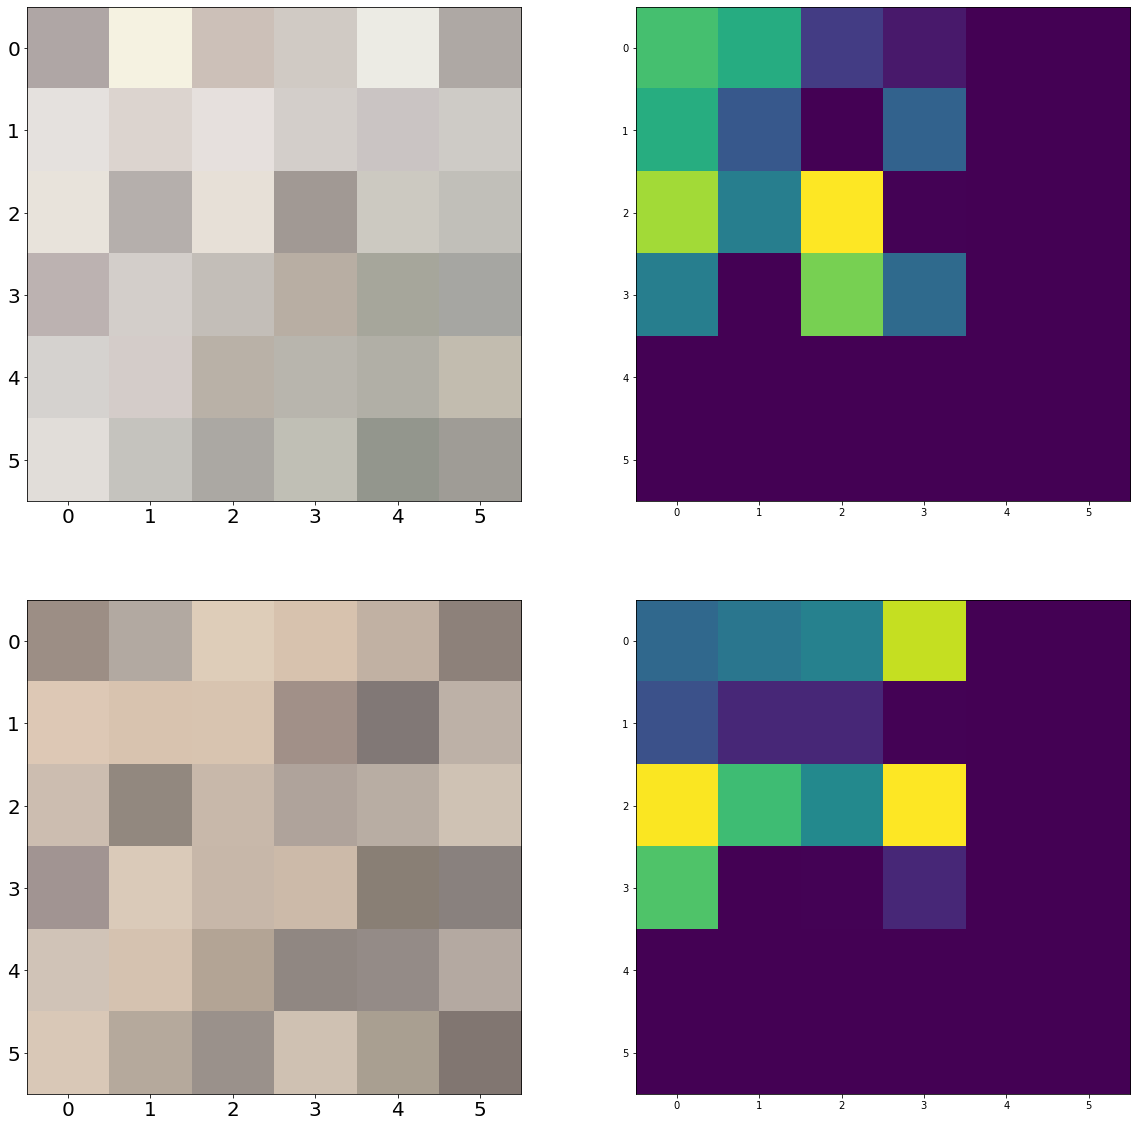

In [22]:
fig=plt.figure(figsize=(20,20))
for i in range(2):
    kk=k[2:][i]
    if kk[-3:]=='png':
        img=imageio.imread(kk)
    else:
        img=torch.load(kk).transpose(1,2,0).astype(np.int)
    ax = fig.add_subplot(2,2,i*2+1)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    # ax.set_ylabel('Post',size = 16)
    # plt.figure(figsize=(10,10))
    ax.imshow(img)
    edge_img=prewitt(img[:,:,1])
    ax2 = fig.add_subplot(2,2,i*2+2)
    ax2.imshow(edge_img)
    # plt.show()

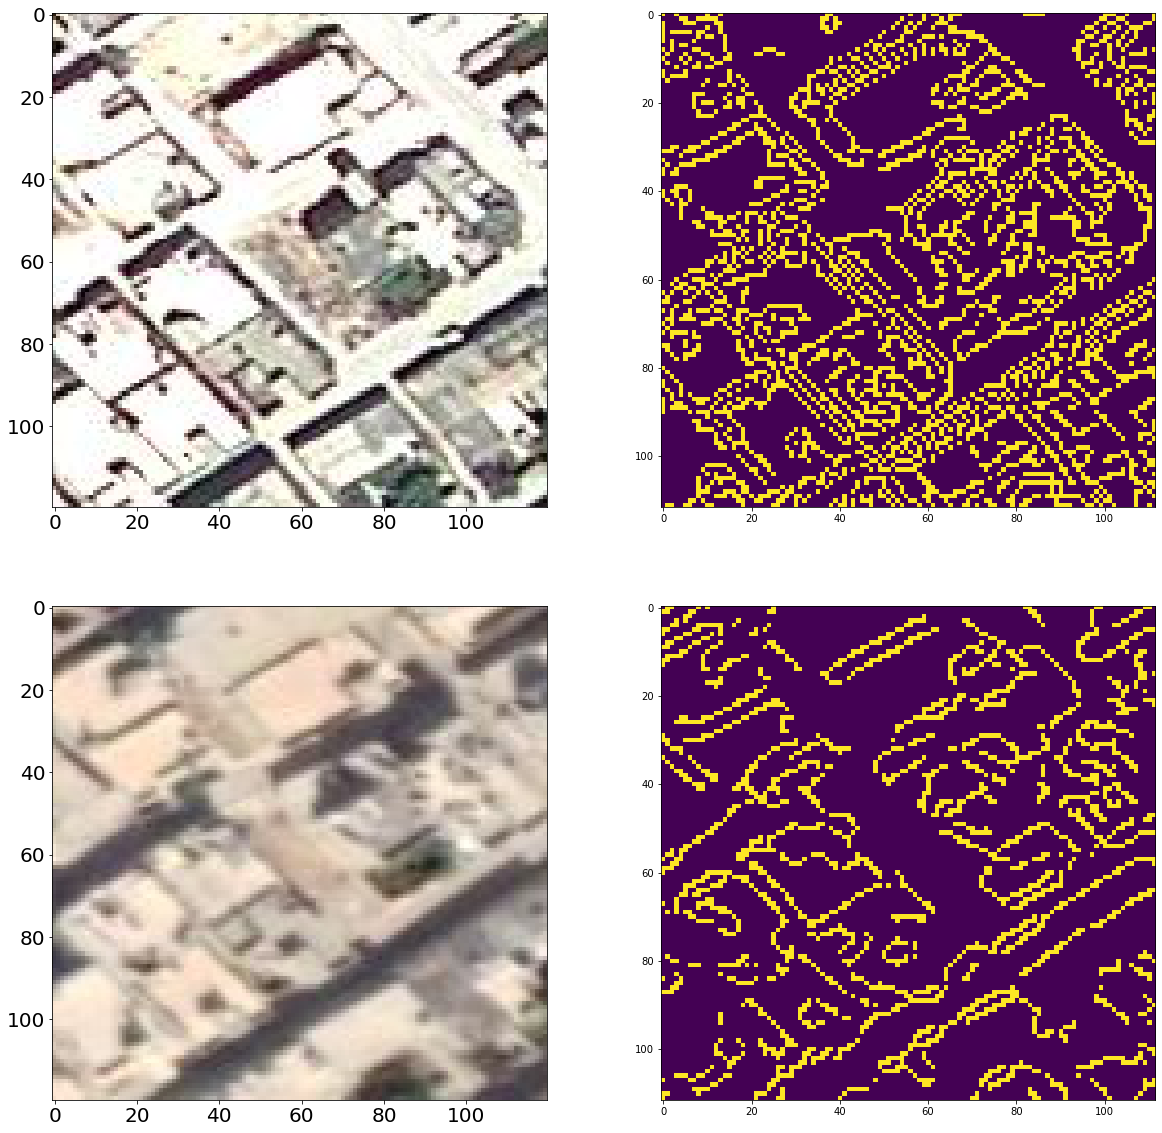

In [24]:

fig=plt.figure(figsize=(20,20))
for i in range(2):
    kk=k[i]
    if kk[-3:]=='png':
        img=imageio.imread(kk)
    else:
        img=torch.load(kk).transpose(1,2,0).astype(np.int)
    ax = fig.add_subplot(2,2,i*2+1)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    # ax.set_ylabel('Post',size = 16)
    # plt.figure(figsize=(10,10))
    ax.imshow(img)
    edge_img=edge_detection(img[:,:,0])
    ax2 = fig.add_subplot(2,2,i*2+2)
    ax2.imshow(edge_img)
    # plt.show()

In [17]:
def prewitt(img):
  r, c = img.shape
  new_image = np.zeros((r, c))
  new_imageX = np.zeros(img.shape)
  new_imageY = np.zeros(img.shape)
  dx = np.array([[0,0,-1],[1,0,-1],[1,0,-1]])
  dy = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
  for i in range(r):
    for j in range(c):
      if (j+3<=c) and (i+3<=r):
        new_imageX[i,j] = (np.sum(img[i:i+3, j:j+3] * dx))**2
        new_imageX[i,j] = (np.sum(img[i:i+3, j:j+3] * dy))**2 
        new_image[i,j] = (new_imageX[i, j]*new_imageX[i,j] + new_imageY[i, j]*new_imageY[i,j])**0.5
  return np.uint8(new_image)


Prewitt = prewitt(img[:,:,1])

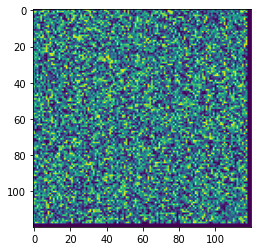

In [18]:
plt.imshow(Prewitt)

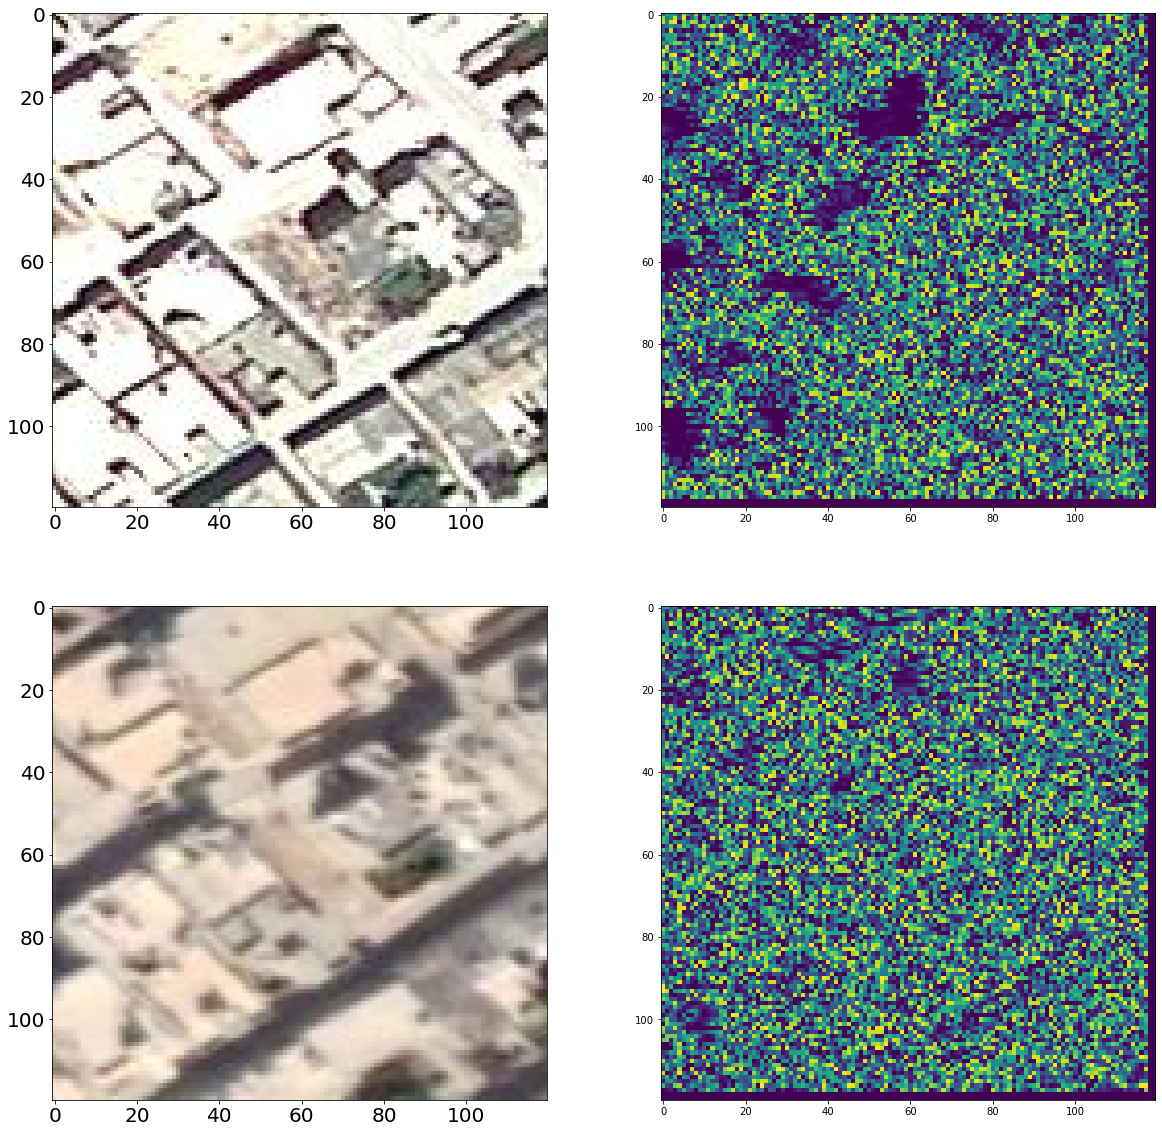

In [23]:

fig=plt.figure(figsize=(20,20))
for i in range(2):
    kk=k[i]
    if kk[-3:]=='png':
        img=imageio.imread(kk)
    else:
        img=torch.load(kk).transpose(1,2,0).astype(np.int)
    ax = fig.add_subplot(2,2,i*2+1)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    # ax.set_ylabel('Post',size = 16)
    # plt.figure(figsize=(10,10))
    ax.imshow(img)
    edge_img=prewitt(img[:,:,1])
    ax2 = fig.add_subplot(2,2,i*2+2)
    ax2.imshow(edge_img)
    # plt.show()